## Anatomia de um serviço de computação quântica 
- linguagem cod em quant : qiskit
- nuvem --> Empacotar o programa --> Servidor --> controle  eletrônioc  --> resultado: convertido em sequências de pulso de micro-ondas --> Executado em um processador quântico real

### O que é o Qiskit
- open-source SDK para trabalhar com qc no nível de circuitos quânticos ,operadores e primitivos. 

#### Qiskit runtime
- Serviço de nuvem para execução qc na IBM

#### Qiskit patterns
- diretrizes para resolver um problema 
1. mapear seu problema 
2. otimizar esse circuito
3. envialo para o hardware
4. pós-processamento 


### Mapear seu problema 
1. construir o circuito 

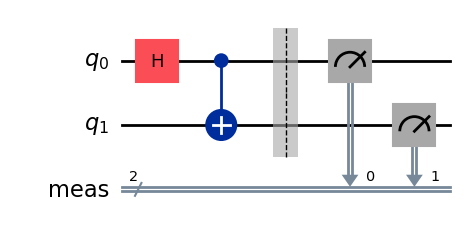

In [1]:
from qiskit import QuantumCircuit, QuantumRegister

qubits = QuantumRegister(2 , name='q') #Registrando 2 qubits
circuit = QuantumCircuit(qubits) #Colocar os qubits em um circuito quântico

q0,q1= qubits 

#gates
circuit.h(q0) #Hadamard --> Superposição
circuit.cx(q0,q1) #CNOT --> Entrelaçamento
circuit.measure_all() #Porta de medição 

circuit.draw('mpl') #Desenhar o circuito(Obs: O uso do mpl é algo relacionado ao estilo)

## Otimização 
- Transpilação  
    - Conjuto limitado de portas pode ser exe diretamento no hardware
    - conectividade correta
    - erro: 
- Otimização (Opcional) --> Circuito ISA (Circuito otimizado)
    - circuito abstrato --> Disp Quântico Especificado 
    - pass: Circ autônomo ou transf de metadados
    - pass manager: Lista de passagens do transpilador agrupadas em uma unidade lógica
    - staged pass manager: Lista de gerenciadores de passes, com cada um representando um estágio discreto de uma pipeline de transpilação 

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

qubits = QuantumRegister(2, name='q')
circuit = QuantumCircuit(qubits)

q0 , q1= qubits
circuit.h(q0)
circuit.cx(q0,q1)

#Transpilação
service = QiskitRuntimeService() #iniciar
backend = service.backend('ibm_brisbane') #Converte o circuito em algo específico para o backend
pass_manager = generate_preset_pass_manager(optimazation_level=3, backend=backend) #
isa_circuit = pass_manager.run(circuit) #Gerar o circuito ISA

isa_circuit.draw('mpl', idle_wires=False)

### Diferentes Tipos de Transpilação 
- Inicialização: Circuito preparado para transpilação
- Layout: qubits abstrato --> Mapeado --> Qubits físicos
- Routing: Portas de trocas são inseridas para permitir interação entre qubits que não estão fisicamento conectados
- Translation: Portas do circuitos são traduzidas para o conjunto de portas 
- Optimization: Circuito reescrito para minimizar profundidade e diminuir efeitos de erros 
- Scheduling: Instruções de atraso(Alinha circuito com o tempo de hardware)

### Simulação
- Primitivas de referência do Qiskit SDK :Simulações exatas(Circuito pequenos e sem simulação de ruido)
- Teste local do Qiskit runtime: Fornece backends 'falsos' para modelar cada máquina quântica. 
- Qiskit Aer: Proj de ecossitema para simulação 
    - Circuito maiores
    - Circuitos Estabilizadores 
    - Modelo de ruído


- simular circuitos quânticos aumenta exp com o número de qubits

- Técnicas de grandes circuitos 
    - Versões menotes
    - Torne classicamente simulável --> Circuito estabilizador(Circuito de Clifford)

### Execução no Hardware

- Primitivo vai encapsular um output de uma circuito quântico
- Primitivo de amostrador: Série de sequências de bits mapeados para númeto de contagens(Depende de portas de medição)
- Primitivo Estimador: Valor esperado de um observável (Não depende de portas de medição)


In [ ]:
import numpy as np 
from qiskit.circuit.library import IQP 
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

service = QiskitRuntimeService()

#Utilizando o Serviço Procurar um dispositivo quântico menos ocupado 
backend = service.least_busy(operational=True,simulator=False, min_num_qubits=127)

n_qubits = 127

mat = np.real(random_hermitian(n_qubits,seed=1234))
circuit =IQP(mat)
circuit.measure_all()

pm = generate_preset_pass_manager(backend=backend,optimization_level=1 )
isa_circuit = pm.run(circuit)

#Inicializando um amostrador 
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()

In [ ]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp , random_hermitian
from qiskit_ibm_runtime import  EstimatorV2 as Estimator, QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True,simulator=False, min_num_qubits=127)
estimator = Estimator(backend)

#Especificando um observavel 
mat =np.real(random_hermitian(n_qubits, seed = 1234))
circuit = IQP(mat)
observable = SparsePauliOp('Z'*n_qubits) #gerar um valor esperado

pm = generate_preset_pass_manager(backend=backend,optimization_level=1 )
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout) #extrair o observável

job= estimator.run([(isa_circuit,isa_observable)])
result =job.result()

print(f'>Expectation value :{result[0].data.evs}')
print(f'>Metadata: {result[0].metadata}')




### Customize Qiskit runtime Behavior 

- shots: reduzir erros estatisticos 
- Erro de supressão: Desacoplamento dinâmico(Diminiu a decoerência de um qubit)
- Erro de mitigação : reduzir o efeito de ruído (Rex and Z)

### Modos de Execução 
- single job
- batch: Multiple jobs
- session: Iteração vários jobs

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler , Batch

max_circuits = 100
all_partitioned_circuits = []
for i in range(0,len(circuits), max_circuits):
        all_partitioned_circuits.append(circuit[i:i+max_circuits])
jobs = []
start_idx = 0

with Batch(backend=backend):
        sampler = Sampler()
        for partitioned_circuits in all_partitioned_circuits:
                job = sampler.run(partitioned_circuits)
                jobs.append(job)    

In [ ]:
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService,Session

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

with Session(backend=backend):
    estimator =Estimator


## Pós-Processamento 
- Visualizar resultados:
    - plot_histogram()
    - post-selection

- Circuit Knitting
    - Corta circuitos 
    - Executar circuitos menores
    - Unir o resultado 

